# Registration of Tungsten fibres on XCT images

This demo aims to demonstrate the use of [gVirtualXRay](http://gvirtualxray.sourceforge.net/) and mathematical optimisation to register polygon meshes onto X-ray microtomography (micro-CT) scans of a tungsten fibre. Below is an example of CT slice.
 
![The fibre.](../scanned_object.png)

Our simulations include beam-hardening due to polychromatism and they take into account the response of the detector.

We use SimpleGVXR's Python wrapper and Python packages commonly used in tomography reconstruction ([Tomopy](https://tomopy.readthedocs.io/en/latest/)), image processing ([scikit-image](https://scikit-image.org/) and [SimpleITK](https://simpleitk.org/)), computer vision ([OpenCV](https://www.opencv.org/)), and non-linear numerical optimization ([CMA-ES, Covariance Matrix Adaptation Evolution Strategy](https://github.com/CMA-ES/pycma)).

## Registration steps

1. Initialisation
    - [Import Python packages](#Import-packages)
    - [Global variables](#Global-variables) with values corresponding to known parameters
    - [Load the image data from the experiment at ESRF](#Load-the-image-data)
    - [Recontruct the corresponding CT data](#CT-Reconstruction)
    - [Normalise the image data](#Normalise-the-image-data)
    - [Set the X-ray simulation environment](#Set-the-X-ray-simulation-environment)
    - [LSF](#The-LSF)
    - [Find circles to identify the centre of fibres](#Find-circles-to-identify-the-centre-of-fibres)
2. [Registration of a cube](#Registration-of-a-cube)
3. [Optimisation of the cores and fibres radii](#Optimisation-of-the-cores-and-fibres-radii)
4. [Recentre each core/fibre](#Recentre-each-core/fibre)
5. [Optimisation the radii after recentring](#Optimisation-the-radii-after-recentring)
6. [Optimisation of the beam spectrum](#Optimisation-of-the-beam-spectrum)
7. [Optimisation of the Poisson noise](#Optimisation-of-the-Poisson-noise)
8. [Optimisation of the phase contrast and the radii](#Optimisation-of-the-phase-contrast-and-the-radii)
9. [Optimisation of the phase contrast and the LSF](#Optimisation-of-the-phase-contrast-and-the-LSF)

## Import packages

We need to import a few libraries (called packages in Python). We use:
 
- `copy`: duplicating images using deepcopies;
- `math`: the `floor` function;
- `os`: creating a new directory
- `glob`: retrieving file names in a directory;
- `numpy`: who doesn't use numpy?
- `imageio`: creating GIF files;
- `skimage`: comparing the reference CT slice and the simulated one, computing the Radon transform of an image, and perform a CT reconstruction using FBP and SART;
- `sklearn`: comparing the reference CT slice and the simulated onecomparing the reference CT slice and the simulated one
- `tomopy`: another package for CT reconstruction;
- `SimpleITK`: image processing and saving volume data;
- OpenCV (`cv2`): Hough transform and bilateral filter (an edge-preserving smoothing filter);
- `matplotlib`: plotting data;
- `cma`: non-linear numerical optimization;
- `lsf`: the line spread function to filter the X-ray images; and
- `gvxrPython3`: simulation of X-ray images using the Beer-Lambert law on GPU.

In [1]:
%matplotlib inline

import copy, math, os, glob

import numpy as np

import imageio
from skimage.transform import iradon
from skimage.util import compare_images
from sklearn.metrics import mean_squared_error
from skimage.util import random_noise

from scipy import ndimage

# import tomopy

import SimpleITK as sitk

import cv2

import cma

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from matplotlib import cm

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

from lsf import *

import gvxrPython3 as gvxr

In [2]:
if not os.path.exists("outputs"):
    os.makedirs("outputs");
    
if not os.path.exists("plots"):
    os.makedirs("plots");

## Global variables

We need some global variables.

- `g_reference_CT`: The reference XCT slice;
- `g_reference_sinogram`: The Radon transform of the reference XCT slice;
- `g_pixel_spacing_in_micrometre` and `g_pixel_spacing_in_mm`: The physical distance between the centre of two successive pixel;
- `g_number_of_projections`: The total number of angles in the sinogram;
- `g_angular_span_in_degrees`: The angular span covered by the sinogram;
- `g_angular_step`: the angular step; and
- `g_theta`: The rotation angles in degrees (vertical axis of the sinogram).


In [3]:
NoneType = type(None);
pixel_spacing_in_micrometre = 1.9;
pixel_spacing_in_mm = pixel_spacing_in_micrometre * 1e-3;
number_of_projections = 900;
angular_span_in_degrees = 180.0;
angular_step = angular_span_in_degrees / number_of_projections;
theta = np.linspace(0., angular_span_in_degrees, number_of_projections, endpoint=False);
roi_length = 40;

value_range = 6;
num_samples = 15;

bias = None;
gain = None;
scale = None;

fibre_radius = 140 / 2; # um
core_radius = 30 / 2; # um

## Load the image data

Load and display the reference projections from a raw binary file, i.e. the target of the registration.

In [4]:
# Target of the registration
reference_normalised_projections = np.fromfile("sino.raw", dtype=np.float32);
reference_normalised_projections.shape = [number_of_projections, int(reference_normalised_projections.shape[0] / number_of_projections)];

In [5]:
def saveMHA(fname, image, spacing):
    """
    save the image into a file.

    :param str fname: the filename
    :param 2D_image image: the image to save
    :param [flt, flt, flt] spacing: the space between two successive voxels along the 3 direction
    """

    #np.savetxt("Tutorial2/outputs/reference_CT.txt", g_reference_CT);
    volume = sitk.GetImageFromArray(image);
    volume.SetSpacing(spacing);
    sitk.WriteImage(volume, fname, useCompression=True);

In [6]:
saveMHA('outputs/reference_normalised_projections.mha', reference_normalised_projections, [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

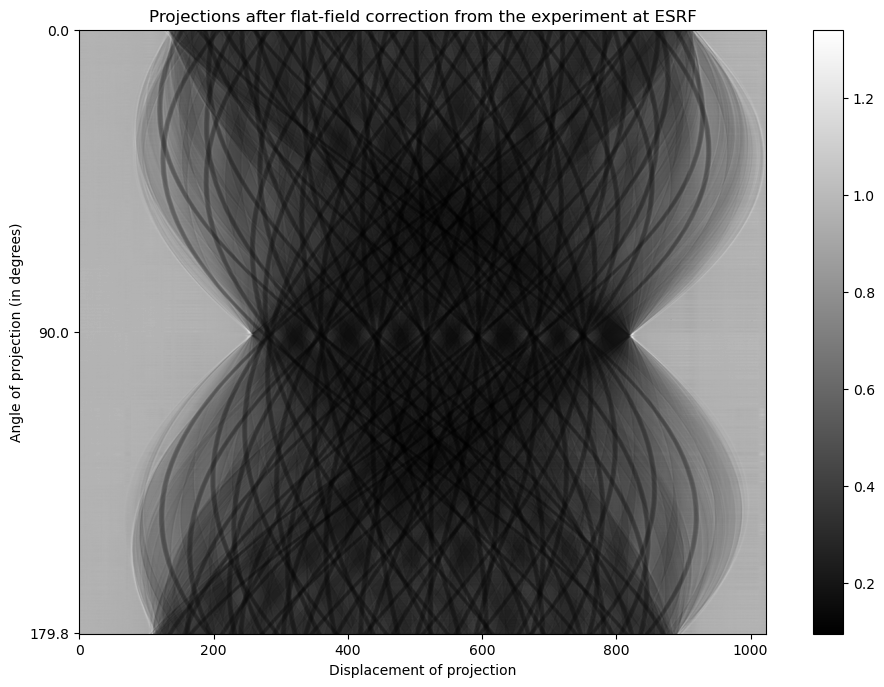

In [7]:
labels=[theta[0], theta[reference_normalised_projections.shape[0] // 2], theta[-1]];
tics=[0, reference_normalised_projections.shape[0] // 2, reference_normalised_projections.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(reference_normalised_projections, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Projections after flat-field correction from the experiment at ESRF");
fig.colorbar(imgplot);
plt.savefig('plots/Normalised_projections_from_experiment_ESRF.pdf')  
plt.savefig('plots/Normalised_projections_from_experiment_ESRF.png')  

In the literature, a projection is often modelled as follows:

$$P = \ln\left(\frac{I_0}{I}\right) = -\ln\left(\frac{I}{I_0}\right) = \sum_n \mu(n) \Delta_x$$


`reference_normalised_projections` loaded from the binary file corresponds to $\frac{I}{I_0}$. The flat-field correction has already been performed. It is now necessary to linearise the transmission tomography data using:

$$-\ln(normalised\_projections)$$ 

This new image corresponds to the Radon transform, known as sinogram, of the scanned object in these experimental conditions. Once this is done, we divide the pixels of the sinogram by $\Delta_x$, which is egal to the spacing between two successive pixels along the horizontal axis.

We define a new function to compute the sinogram from flat-field correction and calls it straightaway.

In [8]:
def computeSinogramFromFlatField(normalised_projections):
    """
    This function apply the minus log normalisation
    on the projections that bave been corrected with the flat-field method.

    :param 2D_image normalised_projections: The projections after flat-field corrections
    :return the sinogram.
    """

    # Create a temporary image to hold the sinogram
    simulated_sinogram = copy.deepcopy(normalised_projections);

    # Make sure no value is negative or null (because of the log function)
    # It should not be the case, however, when the Laplacian is used to simulate
    # phase contrast, negative values can be generated.
    threshold = 0.000001
    simulated_sinogram[simulated_sinogram < threshold] = threshold;

    # Apply the minus log normalisation
    simulated_sinogram = -np.log(simulated_sinogram);

    # Rescale the data taking into account the pixel size
    simulated_sinogram /= pixel_spacing_in_micrometre * gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm");

    # Return the new image
    return simulated_sinogram;


In [9]:
reference_sinogram = computeSinogramFromFlatField(reference_normalised_projections);

In [10]:
saveMHA('outputs/reference_sinogram.mha', reference_sinogram, [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

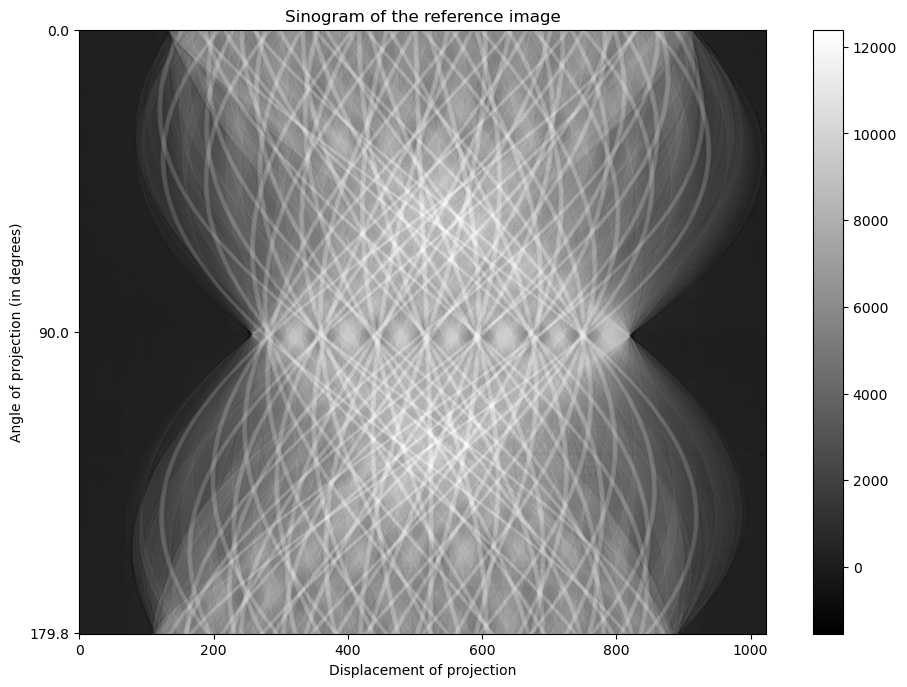

In [11]:
labels=[theta[0], theta[reference_sinogram.shape[0] // 2], theta[-1]];
tics=[0, reference_sinogram.shape[0] // 2, reference_sinogram.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(reference_sinogram, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Sinogram of the reference image");
fig.colorbar(imgplot);
plt.savefig('plots/Sinogram_reference_image.pdf');
plt.savefig('plots/Sinogram_reference_image.png');

## CT reconstruction

Now we got a sinogram, we can reconstruct the CT slice. As we used a synchrotron, we can assume we have a parallel source. It means we can use a FBP rather than the FDK algorithm.

In [12]:
reference_CT = iradon(reference_sinogram.T, theta=theta, circle=True);

In [13]:
saveMHA('outputs/reference_CT.mha', reference_CT, [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

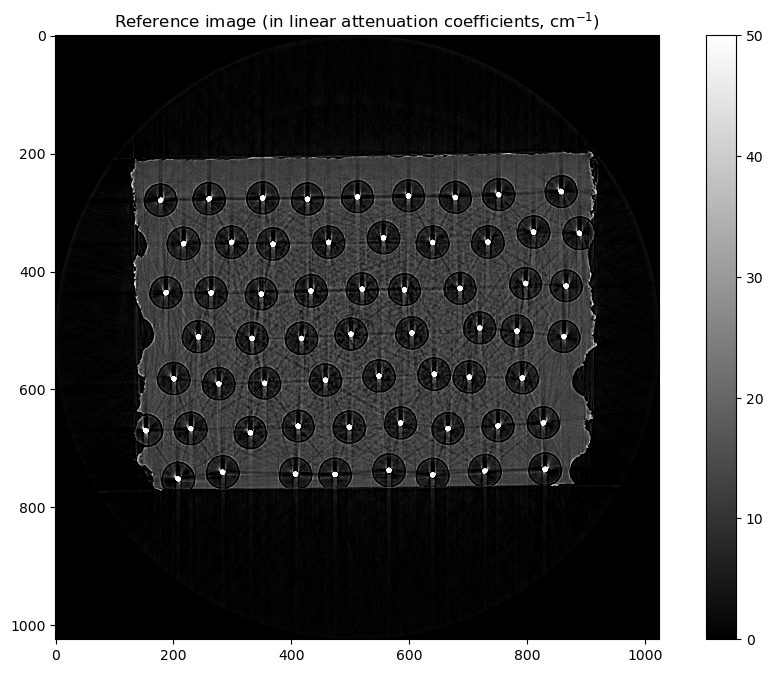

In [14]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=50, vmin=0)
imgplot = plt.imshow(reference_CT, cmap="gray", norm=norm);
fig.colorbar(imgplot);
plt.title("Reference image (in linear attenuation coefficients, cm$^{-1}$)");
plt.savefig('plots/reference_image_in_mu.pdf');
plt.savefig('plots/reference_image_in_mu.png');

## Normalise the image data

Zero-mean unit-variance normalisation is applied to use the reference images in objective functions and perform the registration. Note that it is called standardisation (Z-score Normalisation) in machine learning. It is computed as follows:

$$I' = \frac{I - \bar{I}}{\sigma}$$

Where $I'$ is the image after the original image $I$ has been normalised, $\bar{I}$ is the average pixel value of $I$, and $\sigma$ is its standard deviation.

In [15]:
normalised_reference_sinogram = (reference_sinogram - reference_sinogram.mean()) / reference_sinogram.std();
normalised_reference_CT       = (reference_CT       - reference_CT.mean())       / reference_CT.std();

## Set the X-ray simulation environment

First we create an OpenGL context, here using EGL, i.e. no window.

In [16]:
gvxr.createWindow(0, 1, "EGL");
gvxr.setWindowSize(512, 512);

We set the parameters of the X-ray detector (flat pannel), e.g. number of pixels, pixel, spacing, position and orientation:

![3D scene to be simulated using gVirtualXray](../3d_scene.png)

In [17]:
detector_width_in_pixels = reference_sinogram.shape[1];
detector_height_in_pixels = 1;
distance_object_detector_in_m =    0.08; # = 80 mm

gvxr.setDetectorPosition(-distance_object_detector_in_m, 0.0, 0.0, "m");
gvxr.setDetectorUpVector(0, 1, 0);
gvxr.setDetectorNumberOfPixels(detector_width_in_pixels, detector_height_in_pixels);
gvxr.setDetectorPixelSize(pixel_spacing_in_micrometre, pixel_spacing_in_micrometre, "micrometer");

And the source parameters (beam shape, source position)

In [18]:
# Set up the beam
distance_source_detector_in_m  = 145.0;

gvxr.setSourcePosition(distance_source_detector_in_m - distance_object_detector_in_m,  0.0, 0.0, "m");
gvxr.usePointSource();
# gvxr.useParallelBeam();

The beam spectrum. Here we have a polychromatic beam, with 97% of the photons at 33 keV, 2% at 66 keV and 1% at 99 keV.

In [19]:
energy_spectrum = [(33, 0.97, "keV"), (66, 0.02, "keV"), (99, 0.01, "keV")];

for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

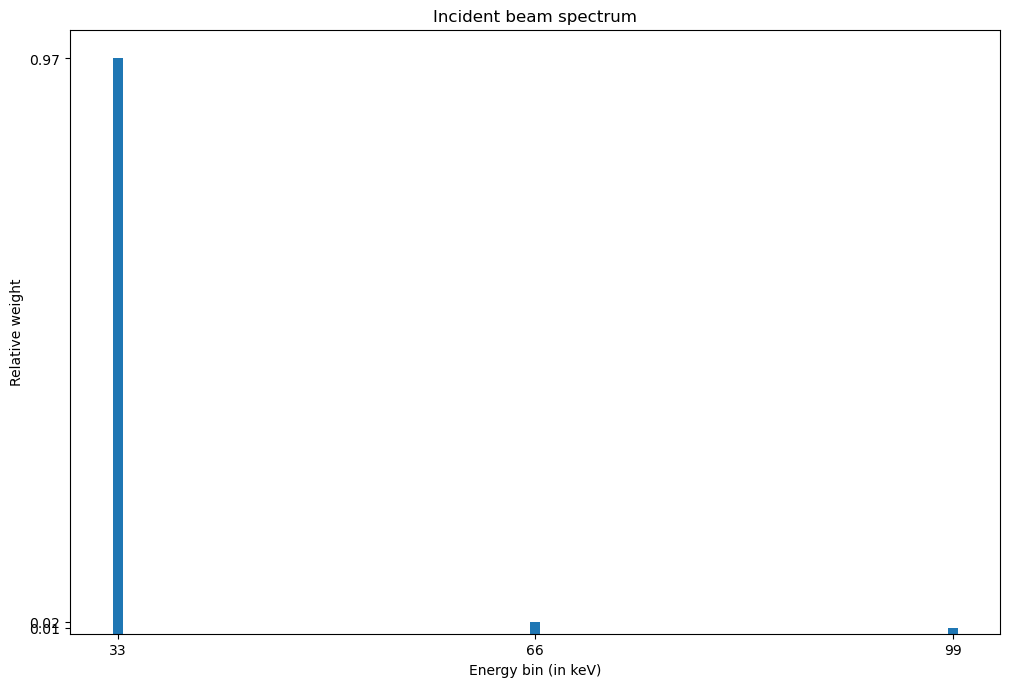

In [20]:
energies_in_keV = [];
weights = [];

for energy, percentage, unit in energy_spectrum:
    weights.append(percentage);
    energies_in_keV.append(energy * gvxr.getUnitOfEnergy(unit) / gvxr.getUnitOfEnergy("keV"));

fig=plt.figure();
plt.xlabel("Energy bin (in keV)");
plt.ylabel("Relative weight");
plt.xticks(energies_in_keV);
plt.yticks(weights);
plt.title("Incident beam spectrum");
plt.bar(energies_in_keV, weights);
plt.savefig('plots/beam_spectrum.pdf');
plt.savefig('plots/beam_spectrum.png');

The material properties (chemical composition and density)

In [21]:
fibre_radius = 140 / 2; # um
fibre_material = [("Si", 0.5), ("C", 0.5)];
fibre_mu = 2.736; # cm-1
fibre_density = 3.2; # g/cm3

core_radius = 30 / 2; # um
core_material = [("W", 1)];
core_mu = 341.61; # cm-1
core_density = 19.3 # g/cm3

g_matrix_width = 0;
g_matrix_height = 0;
g_matrix_x = 0;
g_matrix_y = 0;
matrix_material = [("Ti", 0.9), ("Al", 0.06), ("V", 0.04)];
matrix_mu = 13.1274; # cm-1
matrix_density = 4.42 # g/cm3

### The LSF

In [22]:
t = np.arange(-20., 21., 1.);
lsf_kernel=lsf(t*41)/lsf(0);
lsf_kernel/=lsf_kernel.sum();

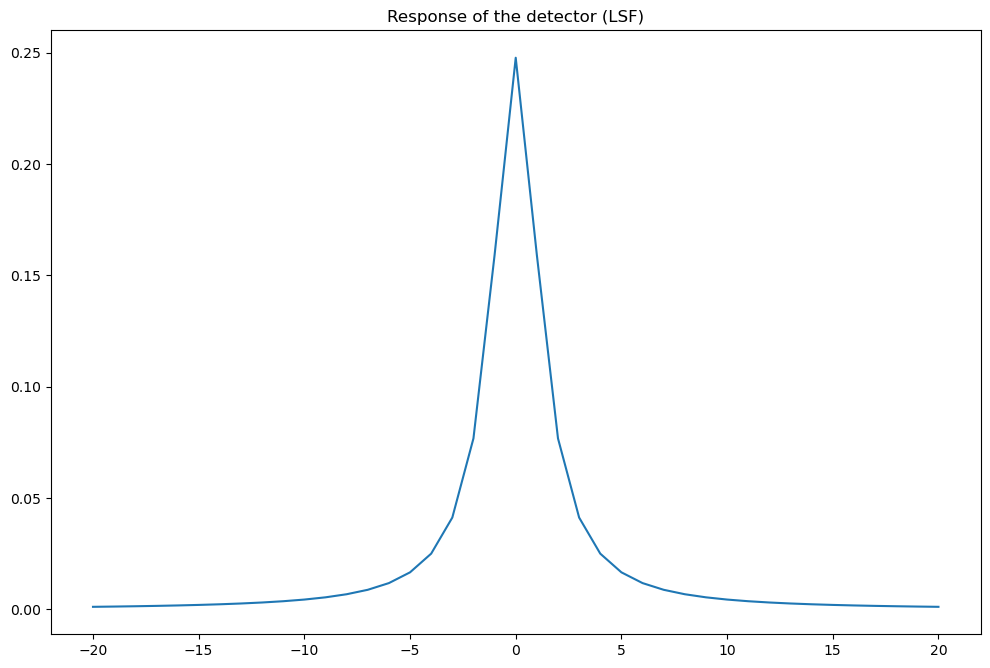

In [23]:
fig=plt.figure();
plt.title("Response of the detector (LSF)");
plt.plot(t, lsf_kernel);
plt.savefig('plots/LSF.pdf');
plt.savefig('plots/LSF.png');

## Find circles to identify the centre of fibres

We can use the Hoguh transform to detect where circles are in the image. However, the input image in OpenCV's function must be in UINT8. We blur it using a bilateral filter (an edge-preserving smoothing filter).

### Convert the image to UINT8

We first create a function to convert images in floating point numbers into UINT8.

In [24]:
def float2uint8(anImage):
    uchar_image = copy.deepcopy(anImage);
    uchar_image -= np.min(uchar_image);
    uchar_image /= np.max(uchar_image);
    uchar_image *= 255;
    return uchar_image.astype(np.uint8);

We blur the CT scan using a bilateral filter. It preserves edges.

In [25]:
uint8_reference_CT = float2uint8(reference_CT);
blurred_reference_CT = cv2.bilateralFilter(uint8_reference_CT, 9, 75, 75);

saveMHA('outputs/blurred_reference_CT.mha', blurred_reference_CT, [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

### Apply the Hough transform

In [26]:
circles = cv2.HoughCircles(blurred_reference_CT, cv2.HOUGH_GRADIENT, 2, 80,
                            param1=150, param2=5, minRadius=5, maxRadius=15);

### Overlay the detected circles on the top of the image

In [27]:
cimg = cv2.cvtColor(blurred_reference_CT, cv2.COLOR_GRAY2BGR);
circles = np.uint16(np.around(circles));

for i in circles[0,:]:
    
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2);
    
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3);

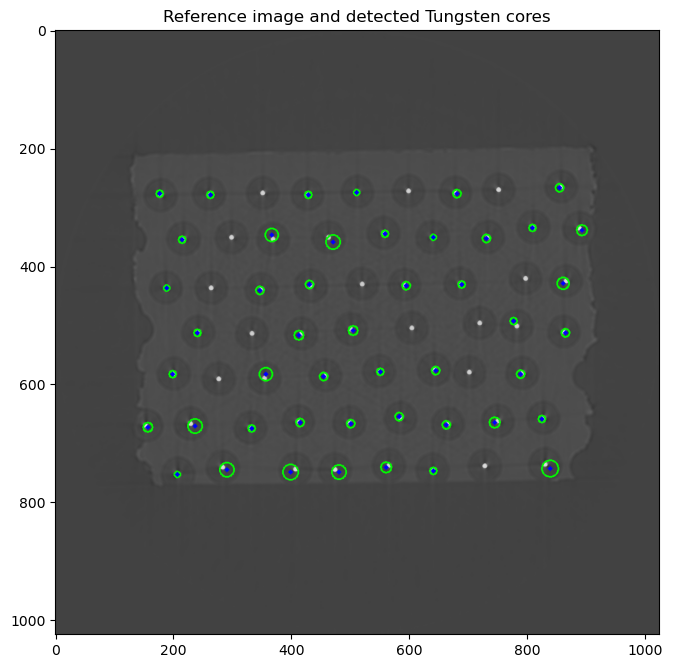

In [28]:
fig=plt.figure();
imgplot = plt.imshow(cimg);
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_Hough_transform.pdf');
plt.savefig('plots/fibre_detection_using_Hough_transform.png');

Unlike the previous example, did did not work that well. Here 13 fibres were missed. Many centres are also misplaced. We will use another technique to register the fibres, the popular Otsu's method. It creates a histogram and uses a heuristic to determine a threshold value.

In [29]:
# Convert the numpy array in float32 into uint8, then into a SITK image
volume = sitk.GetImageFromArray(float2uint8(reference_CT));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

# Apply the Otsu's method
otsu_filter = sitk.OtsuThresholdImageFilter();
otsu_filter.SetInsideValue(0);
otsu_filter.SetOutsideValue(1);
seg = otsu_filter.Execute(volume);

# Print the corresponding threshold
print("Threshold:", otsu_filter.GetThreshold());

Threshold: 139.0


In [30]:
sitk.WriteImage(seg, "outputs/cores_segmentation.mha", useCompression=True);

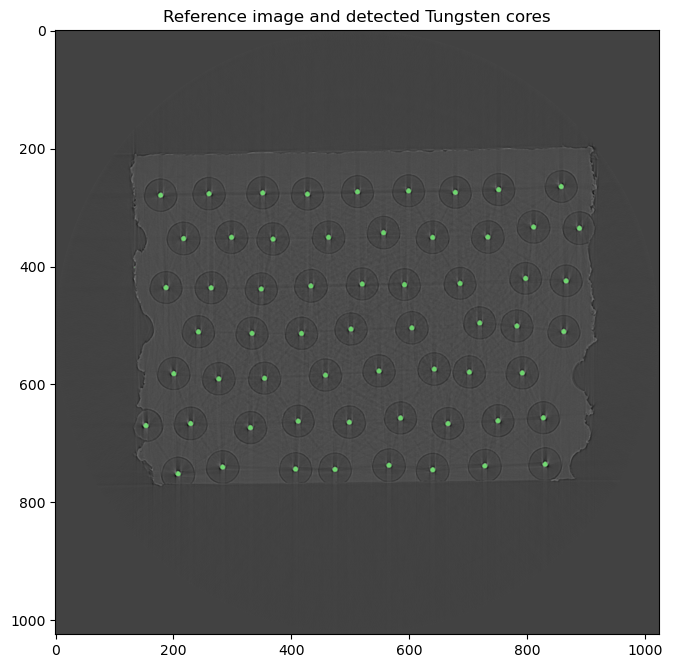

In [31]:
fig=plt.figure();
imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, seg)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_otsu_method.pdf');
plt.savefig('plots/fibre_detection_using_otsu_method.png');

### Clean up

In [32]:
# Clean-up using mathematical morphology
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(seg, [3, 3, 3])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [3, 3, 3])

In [33]:
sitk.WriteImage(cleaned_thresh_img, "outputs/cores_cleaned_segmentation.mha", useCompression=True);

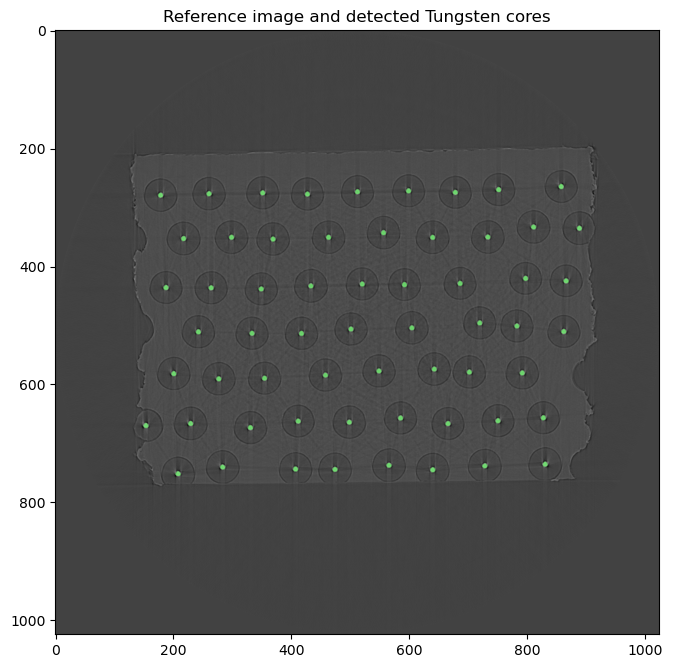

In [34]:
fig=plt.figure();
imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, cleaned_thresh_img)));
plt.title("Reference image and detected Tungsten cores");
plt.savefig('plots/fibre_detection_using_otsu_method_after_cleaning.pdf');
plt.savefig('plots/fibre_detection_using_otsu_method_after_cleaning.png');

## Mark each potential tungsten corewith unique label

In [35]:
core_labels = sitk.ConnectedComponent(cleaned_thresh_img);

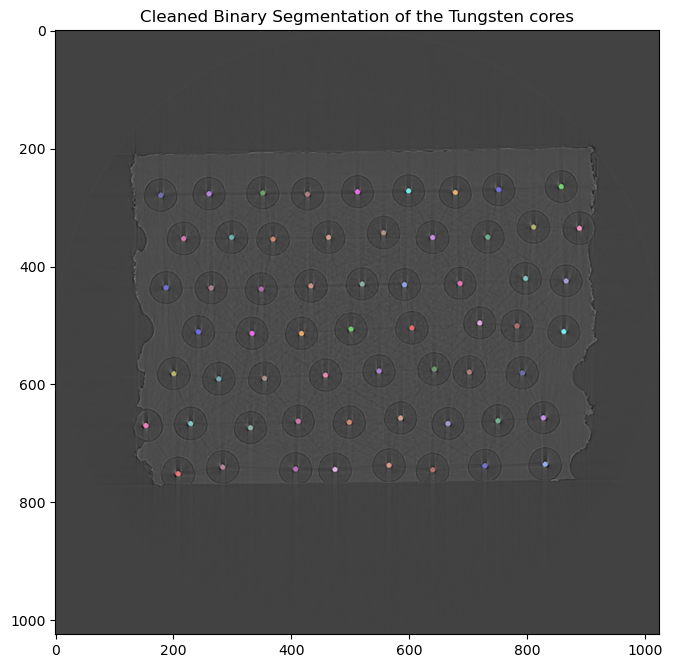

In [36]:
fig=plt.figure();
imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, core_labels)));
plt.title("Cleaned Binary Segmentation of the Tungsten cores");
plt.savefig('plots/fibre_detection_with_label_overlay.pdf');
plt.savefig('plots/fibre_detection_with_label_overlay.png');

### Object Analysis

Once we have the segmented objects we look at their shapes and the intensity distributions inside the objects. For each labelled tungsten core, we extract the centroid. Note that sizes and positions are given in millimetres.

In [37]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(core_labels)

In [38]:
centroid_set = [];

for i in shape_stats.GetLabels():
    centroid_set.append(cleaned_thresh_img.TransformPhysicalPointToIndex(shape_stats.GetCentroid(i)));

We now have a list of the centres of all the fibres that can be used as a parameter of the function below to create the cylinders corresponding to the cores and the fibres. 
For each core, a cylinder is creatd and translated:
```python
        gvxr.emptyMesh("core_"  + str(i));
        gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");
        gvxr.translateNode("core_"  + str(i), y, 0.0, x, "micrometer");
```
For each fibre, another cylinder is created and translated:
```python
        gvxr.emptyMesh("fibre_"  + str(i));
        gvxr.makeCylinder("fibre_"  + str(i), number_of_sectors, 815.0,  fibre_radius, "micrometer");
        gvxr.translateNode("fibre_"  + str(i), y, 0.0, x, "micrometer");
```
The fibre's cylinder is hollowed to make space for its core:
```python
        gvxr.subtractMesh("fibre_" + str(i), "core_" + str(i));
```

In [39]:
def setFibres(aCentroidSet):
    """This function loads a cylinders in the GPU memory.
    Some are hollow and represent the fibres, some are not and
    correspond to the cores.

    :param array aCentroidSet: a list of cylinder centres.
    """

    global core_radius;
    global fibre_radius;

    # Create empty geometries
    gvxr.emptyMesh("fibre");
    gvxr.emptyMesh("core");

    # Number of sectors to approximate cylinders with triangle meshes
    # It controls the accuracy of the meshes.
    number_of_sectors = 100;

    # Process all the centres from the input list
    for i, cyl in enumerate(aCentroidSet):

        # Convert the centre position from 2D image coordinates in 3D world coordinates
        x = pixel_spacing_in_micrometre * -(cyl[0] - reference_CT.shape[1] / 2 + 0.5);
        y = pixel_spacing_in_micrometre * (cyl[1] - reference_CT.shape[0] / 2 + 0.5);

        # Create empty geometries (is it needed?)
        gvxr.emptyMesh("fibre_" + str(i));
        gvxr.emptyMesh("core_"  + str(i));

        # Create the two corresponding cylinders (fibre and core)
        gvxr.makeCylinder("fibre_" + str(i), number_of_sectors, 815.0, fibre_radius, "micrometer");
        gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");

        # Translate the two cylinders to the position of their centre
        gvxr.translateNode("fibre_" + str(i), y, 0.0, x, "micrometer");
        gvxr.translateNode("core_"  + str(i), y, 0.0, x, "micrometer");

        # Apply the local transformation matrix (so that we could save the corresponding STL files)
        gvxr.applyCurrentLocalTransformation("fibre_" + str(i));
        gvxr.applyCurrentLocalTransformation("core_" + str(i));

        # Subtract the fibre from the matrix
        gvxr.subtractMesh("matrix", "fibre_" + str(i));

        # Subtract the core from the fibre
        gvxr.subtractMesh("fibre_" + str(i), "core_" + str(i));

        # Save the corresponding STL files
        #gvxr.saveSTLfile("fibre_" + str(i), "Tutorial2/outputs/fibre_" + str(i) + ".stl");
        #gvxr.saveSTLfile("core_" + str(i),  "Tutorial2/outputs/core_"  + str(i) + ".stl");

        # Add the mesh of the current fibre to the overall fibre mesh
        gvxr.addMesh("fibre", "fibre_" + str(i));

        # Add the mesh of the current core to the overall core mesh
        gvxr.addMesh("core",  "core_"  + str(i));

    # Set the mesh colours (for the interactive visualisation)
    gvxr.setColor("fibre", 1.0, 0.0, 0.0, 1.0);
    gvxr.setColor("core",  1.0, 0.0, 1.0, 1.0);

    # Set the fibre's material properties
    #gvxr.setLinearAttenuationCoefficient("fibre", fibre_mu, "cm-1");
    gvxr.setCompound("fibre", "SiC");
    gvxr.setDensity("fibre", fibre_density, "g/cm3");

    # Set the core's material properties
    #gvxr.setLinearAttenuationCoefficient("core", core_mu, "cm-1");
    gvxr.setElement("core", "W");

    # Add the fibres and cores to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("core");
    gvxr.addPolygonMeshAsInnerSurface("fibre");

## Registration of a cube

We define a function to create the polygon mesh of the Ti90Al6V4 matrix.

In [40]:
def setMatrix(apGeneSet):
    """This function loads a cube in the GPU memory. The cube represents
    the Ti90Al6V4 matrix.

    apGeneSet[0] is a number between -0.5 and 0.5, related to the translation vector (X component) of the cube. It can be interpreted as a percentage of the detector width.
    apGeneSet[1] is the same as apGeneSet[0], but related to the Y component of the translation vector.
    apGeneSet[2] is a number between -0.5 and 0.5, related to the rotation angle in degrees
    apGeneSet[3] is a scaling factor between -0.5 and 0.5. It can be interpreted as a percentage of the detector width.
    apGeneSet[4] is a scaling factor between -0.5 and 0.5. It can be interpreted as a percentage of apGeneSet[3].
    """

    # Remove all the geometries from the whole scenegraph
    gvxr.removePolygonMeshesFromSceneGraph();

    # Make a cube
    gvxr.makeCube("matrix", 1.0, "micrometer");

    # Translation vector
    x = apGeneSet[0] * detector_width_in_pixels * pixel_spacing_in_micrometre;
    y = apGeneSet[1] * detector_width_in_pixels * pixel_spacing_in_micrometre;
    gvxr.translateNode("matrix", x, 0.0, y, "micrometer");

    # Rotation angle
    rotation_angle_in_degrees = (apGeneSet[2] + 0.5) * 180.0;
    gvxr.rotateNode("matrix", rotation_angle_in_degrees, 0, 1, 0);

    # Scaling factors
    w = (apGeneSet[3] + 0.5) * detector_width_in_pixels * pixel_spacing_in_micrometre;
    h = (apGeneSet[4] + 0.5) * w;
    gvxr.scaleNode("matrix", w, 815, h);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("matrix");

    # Set the matrix's material properties
    gvxr.setMixture("matrix", "Ti90Al6V4");
    gvxr.setDensity("matrix", matrix_density, "g/cm3");

    # Add the matrix to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("matrix");

### Simulate the CT acquisition

1. Set the fibre and cores geometries and material properties (Step 39)
2. Set the matrix geometry and material properties (Step 40)
3. Simulate the raw projections for each angle:
   - Without phase contrast (Line 5 of Step 45), or
   - With phase contrast (Lines 14-55 of Step 45)
4. Apply the LSF (Lines 57-60 of Step 45)
5. Apply the flat-field correction (Step 62)
6. Add Poison noise (Step~\ref{??})
7. Apply the minus log normalisation to compute the sinogram (Step 63)

Compute the raw projections and save the data. For this  purpose, we define a new function.

In [41]:
def tomographyAcquisition():
    """
    This function simulate a CT acquisition.

    :return the raw projections in keV
    """

    # Crete a new array to save every projection in default unit of energy
    raw_projections = [];

    # For each angle, simulate a projection
    for angle_id in range(0, number_of_projections):

        # Reset the transformation matrix and rotate the scnned object
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-angular_step * angle_id, 0, 1, 0);

        # Compute the X-ray image
        xray_image = np.array(gvxr.computeXRayImage());

        # Add the projection
        raw_projections.append(xray_image);

    # Convert from the default unit of energy to keV
    raw_projections = np.array(raw_projections);
    raw_projections_in_keV = raw_projections / gvxr.getUnitOfEnergy("keV");

    return raw_projections_in_keV;


### Flat-filed correction

Because the data suffers from a fixed-pattern noise in X-ray imaging in
actual experiments, it is necessary to perform the flat-field correction of
the raw projections using:

$$corrected\_projections = \frac{raw\_projections\_in\_keV − dark\_field\_image}{flat\_field\_image − dark\_field\_image}$$

- $raw\_projections\_in\_keV$ are the raw projections with the X-ray beam turned on and with the scanned object,
- $flat\_field\_image$ is an image with the X-ray beam turned on but without the scanned object, and
- $dark\_field\_image$ is an image with the X-ray beam turned off.

Note that in our example, $raw\_projections\_in\_keV$, $flat\_field\_image$ and $dark\_field\_image$ are in keV whereas $corrected\_projections$ does not have any unit:

$$0 \leq raw\_projections\_in\_keV \leq  \sum_E N_0(E) \times E\\0 \leq corrected\_projections \leq 1$$

We define a new function to compute the flat-field correction.

In [42]:
def flatFieldCorrection(raw_projections_in_keV):
    """
    This function applies the flat-field correction on raw projections.

    :param 2D_image raw_projections_in_keV: the raw X-ray projections in keV
    :return the projections (raw_projections_in_keV) after flat-field correction
    """

    # Create a mock dark field image
    dark_field_image = np.zeros(raw_projections_in_keV.shape);

    # Create a mock flat field image
    flat_field_image = np.ones(raw_projections_in_keV.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("keV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image *= total_energy;

    # Apply the actual flat-field correction on the raw projections
    corrected_projections = (raw_projections_in_keV - dark_field_image) / (flat_field_image - dark_field_image);

    return corrected_projections;

The function below is used to simulate a sinogram acquisition. Phase contrast in the projections can be taken into account or not.

In [43]:
def simulateSinogram(sigma_set = None, k_set = None, name_set = None):

    global lsf_kernel;

    # Do not simulate the phase contrast using a Laplacian
    if isinstance(sigma_set, NoneType) or isinstance(k_set, NoneType) or isinstance(name_set, NoneType):

        # Get the raw projections in keV
        raw_projections_in_keV = tomographyAcquisition();

    # Simulate the phase contrast using a Laplacian
    else:

        # Create the convolution filter
        pixel_range = np.linspace(-value_range, value_range, num=int(num_samples), endpoint=True)
        laplacian_kernels = {};

        # Store the L-buffers
        L_buffer_set = {};

        # Look at all the children of the root node
        for label in ["core", "fibre", "matrix"]:
            # Get its L-buffer
            L_buffer_set[label] = getLBuffer(label);

        # Create blank images
        raw_projections_in_keV = np.zeros(L_buffer_set["fibre"].shape);
        phase_contrast_image = np.zeros(L_buffer_set["fibre"].shape);

        for label, k, sigma in zip(name_set, k_set, sigma_set):
            laplacian_kernels[label] = k * laplacian(pixel_range, sigma);

            for z in range(phase_contrast_image.shape[0]):
                for y in range(phase_contrast_image.shape[1]):
                    phase_contrast_image[z][y] += ndimage.convolve((L_buffer_set[label])[z][y], laplacian_kernels[label], mode='wrap');

        for energy, photon_count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):

            # Create a blank image
            attenuation = np.zeros(L_buffer_set["fibre"].shape);

            # Look at all the children of the root node
            #for label in ["core", "fibre", "matrix"]:
            for label in ["core", "fibre", "matrix"]:
                # Get mu for this object for this energy
                mu = gvxr.getLinearAttenuationCoefficient(label, energy, "keV");

                # Compute sum mu * x
                attenuation += L_buffer_set[label] * mu;

            # Store the projection for this energy channel
            raw_projections_in_keV += energy * photon_count * np.exp(-attenuation);

        # Apply the phase contrast
        raw_projections_in_keV -= phase_contrast_image;

    # Apply the LSF line by line
    for z in range(raw_projections_in_keV.shape[0]):
        for y in range(raw_projections_in_keV.shape[1]):
            raw_projections_in_keV[z][y] = ndimage.convolve(raw_projections_in_keV[z][y], lsf_kernel, mode='wrap');

    # Flat-field correction
    normalised_projections = flatFieldCorrection(raw_projections_in_keV);
    normalised_projections[normalised_projections < 0] = 0;

    # Add noise
    if not isinstance(bias, NoneType) and not isinstance(gain, NoneType) and not isinstance(scale, NoneType):

        map = (normalised_projections + (bias + 1)) * gain;
        temp = np.random.poisson(map).astype(np.float);
        temp /= gain;
        temp -= bias + 1;

        # Noise map
        noise_map = (normalised_projections - temp) * scale;
        normalised_projections += noise_map;
        
    # Linearise
    simulated_sinogram = computeSinogramFromFlatField(normalised_projections);

    return simulated_sinogram, normalised_projections, raw_projections_in_keV;

The function below is used quantify the differences between two images. It is used in the objective function.

In [44]:
def metrics(ref, test):

    normalised_ref = ref.flatten();
    normalised_test = test.flatten();

    normalised_ref  -= normalised_ref.mean();
    normalised_test -= normalised_test.mean();
    normalised_ref  /= normalised_ref.std();
    normalised_test /= normalised_test.std();

    return math.sqrt(mean_squared_error(normalised_ref, normalised_test));

The function below is the objective function used to register the matrix.

In [45]:
def fitnessFunctionCube(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    global reference_sinogram;
    global centroid_set;
    global use_fibres;

    global core_radius;
    global fibre_radius;

    # Load the matrix geometrical properties from x
    setMatrix(x);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

    # Compute the objective value
    objective = metrics(reference_sinogram, simulated_sinogram);

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        matrix_geometry_parameters = copy.deepcopy(x);
        
        gvxr.saveSTLfile("matrix", "outputs/matrix_" + str(best_fitness_id) + ".stl");
        
        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
        
        # Reconstruct the CT slice
        simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);

        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        best_fitness_id += 1;
            
    return objective

In [46]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/cube.dat"):
    matrix_geometry_parameters = np.loadtxt("outputs/cube.dat");
# Perform the registration using CMA-ES
else:
    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "cube_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = [5*[-0.5], 5*[0.5]];

    es = cma.CMAEvolutionStrategy([0.0, 0.0, 0.0, 0.256835938, 0.232903226], 0.5, opts);
    es.optimize(fitnessFunctionCube);

    matrix_geometry_parameters = copy.deepcopy(es.result.xbest);
    np.savetxt("outputs/cube.dat", matrix_geometry_parameters, header='x,y,rotation_angle,w,h');

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=769481, Thu Apr 29 17:32:50 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 8.797980844271109e-01 1.0e+00 4.38e-01  4e-01  5e-01 0:42.7
    2     16 9.849933135326715e-01 1.2e+00 4.09e-01  3e-01  4e-01 0:47.3
    3     24 9.844200788333163e-01 1.4e+00 3.76e-01  3e-01  4e-01 0:52.2
    4     32 6.930950789572755e-01 1.5e+00 3.61e-01  3e-01  4e-01 1:06.1
    5     40 9.293059250612746e-01 1.7e+00 3.90e-01  3e-01  4e-01 1:10.6
    7     56 9.960254989946028e-01 2.0e+00 3.85e-01  3e-01  4e-01 1:19.7
    9     72 7.597052043204545e-01 2.6e+00 3.76e-01  2e-01  4e-01 1:28.9
   11     88 6.867311644411925e-01 2.4e+00 3.59e-01  2e-01  4e-01 1:47.3
   13    104 6.544822080250594e-01 2.4e+00 2.96e-01  2e-01  3e-01 2:05.3
   15    120 5.707478194537363e-01 2.7e+00 2.72e-01  1e-01  3e-01 2:34.0
   16    128 4.985816567613370e-01 2.6e+00 2.45e-01  1e-01  3e-01 2:47.6
   18    144 4.695495935288412e-01 

### Apply the result of the registration

In [47]:
# Save the result
setMatrix(matrix_geometry_parameters);
gvxr.saveSTLfile("matrix", "outputs/matrix.stl");

# Translation vector
x = matrix_geometry_parameters[0] * detector_width_in_pixels * pixel_spacing_in_micrometre;
y = matrix_geometry_parameters[1] * detector_width_in_pixels * pixel_spacing_in_micrometre;

# Rotation angle
rotation_angle_in_degrees = (matrix_geometry_parameters[2] + 0.5) * 180.0;

# Scaling factors
w = (matrix_geometry_parameters[3] + 0.5) * detector_width_in_pixels * pixel_spacing_in_micrometre;
h = (matrix_geometry_parameters[4] + 0.5) * w;

print("Matrix");
print("\tposition:", x, y, "um");
print("\trotation:", rotation_angle_in_degrees, "deg");
print("\tsize:", w, h, "um");

Matrix
	position: -55.82766230642614 -22.80317233285621 um
	rotation: 90.78122652385588 deg
	size: 1454.1285834091495 1073.8384786733918 um


### Simulate the correspond CT acquisition

In [48]:
# Simulate a sinogram
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);

# Reconstruct the CT slice
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC matrix registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC matrix registration: 45.29


### Display the result of the registration as an animation

In [49]:
def createAnimation(aPrefix, anOutputFile):
    # Find all the images from the output directory
    files = sorted(
        glob.glob(aPrefix + "[0-9]*.mha"))

    # Store the images
    registration_image_set = [];

    # Create the GIF file
    with imageio.get_writer(anOutputFile, mode='I') as writer:

        # Store the PNG filenames
        png_filename_set = [];

        # Process all the images
        for i in range(len(files)):

            # Create the filenames
            mha_fname = aPrefix + str(i) + ".mha";
            png_filename_set.append(aPrefix + str(i) + ".png");

            # Open the MHA file
            float_image = sitk.ReadImage(mha_fname);

            # Convert in a Numpy array
            narray = sitk.GetArrayFromImage(float_image);
            
            narray -= narray.mean();
            narray /= narray.std();
            registration_image_set.append(narray);

            # Create the figure
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            # Dispay the reference, registration and error map
            fig.suptitle('Registration: Result ' + str(i+1) + "/" + str(len(files)))
            plt.tight_layout();
            norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

            # Reference
            ax1.set_title("Reference image");
            imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                                 norm=norm);

            # Registration
            ax2.set_title("Simulated CT slice after automatic registration");
            imgplot2 = ax2.imshow(narray,
                                 cmap='gray',
                                 norm=norm);

            # Error map
            comp_equalized = compare_images(normalised_reference_CT, narray, method='checkerboard');
            ax3.set_title("Checkboard comparison between\nthe reference and simulated images\nZNCC: " + "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, narray))));
            imgplot3 = ax3.imshow(comp_equalized,
                                 cmap='gray',
                                 norm=norm);

            plt.tight_layout();

            # Save the figure as a PNG file
            plt.savefig(png_filename_set[i])

            # Close the figure
            plt.close()

            # Open the PNG file with imageio and add it to the GIF file
            image = imageio.imread(png_filename_set[i])
            writer.append_data(image)

            # Delete the PNG file
            os.remove(png_filename_set[i]);
        
        for i in range(15):
            writer.append_data(image)

    return registration_image_set;

In [50]:
if not os.path.exists("plots/cube_registration.gif"):
    cube_registration_image_set = createAnimation("outputs/cube_simulated_CT_",
                'plots/cube_registration.gif');

![Animation of the registration (GIF file)](plots/cube_registration.gif)

### Adding the fibres

The radius of a tungsten core is 30 / 2 um. The pixel spacing is 1.9 um. The radius in number of pixels is $15/1.9  \approx  7.89$. The area of a core is $(15/1.9)^2  \pi  \approx 196$ pixels.

In [51]:
setMatrix(matrix_geometry_parameters);
setFibres(centroid_set);

In [52]:
# Simulate a sinogram
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

In [53]:
simulated_sinogram.shape     = (simulated_sinogram.size     // simulated_sinogram.shape[2],     simulated_sinogram.shape[2]);
normalised_projections.shape = (normalised_projections.size // normalised_projections.shape[2], normalised_projections.shape[2]);
raw_projections_in_keV.shape = (raw_projections_in_keV.size // raw_projections_in_keV.shape[2], raw_projections_in_keV.shape[2]);

saveMHA("outputs/simulated_sinogram_with_fibres.mha",
        simulated_sinogram,
        [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

saveMHA("outputs/normalised_projections_with_fibres.mha",
        normalised_projections,
        [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

saveMHA("outputs/raw_projections_in_keV_with_fibres.mha",
        raw_projections_in_keV,
        [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

In [54]:
# Reconstruct the CT slice
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC matrix registration with fibres:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC matrix registration with fibres: 56.03


In [55]:
saveMHA("outputs/simulated_CT_with_fibres.mha",
        simulated_CT,
        [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

saveMHA("outputs/normalised_simulated_CT_with_fibres.mha",
        normalised_simulated_CT,
        [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

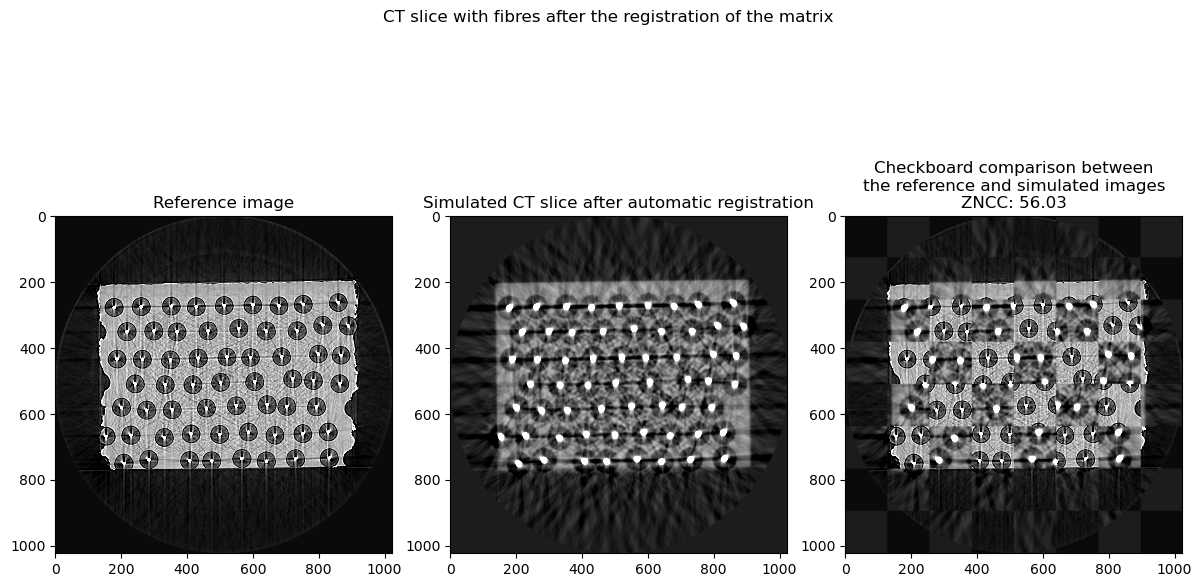

In [56]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('CT slice with fibres after the registration of the matrix')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(normalised_simulated_CT,
                     cmap='gray',
                     norm=norm);

comp_equalized = compare_images(normalised_reference_CT, normalised_simulated_CT, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm);

plt.savefig('plots/simulated_CT_slice_with_fibres_after_cube_registration.pdf');
plt.savefig('plots/simulated_CT_slice_with_fibres_after_cube_registration.png');


## Optimisation of the cores and fibres radii

The function below is the objective function used to optimise the radii of the cores and fibres.

In [57]:
def fitnessFunctionFibres(x):
    global best_fitness;
    global best_fitness_id;
    global fibre_radius;
    global core_radius;
    global prefix;

    # Get the radii
    fibre_radius = x[0];
    core_radius = fibre_radius * x[1];

    # Load the matrix
    setMatrix(matrix_geometry_parameters);

    # Load the cores and fibres
    setFibres(centroid_set);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

    # Compute the objective value
    objective = metrics(reference_sinogram, simulated_sinogram);

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        gvxr.saveSTLfile("core",  "outputs/" + prefix + str(best_fitness_id) + "_cores.stl");
        gvxr.saveSTLfile("fibre", "outputs/" + prefix + str(best_fitness_id) + "_fibres.stl");
        
        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
        
        # Reconstruct the CT slice
        simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);

        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        best_fitness_id += 1;

    return objective

In [58]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/fibre1_radii.dat"):
    temp = np.loadtxt("outputs/fibre1_radii.dat");
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "fibre1_";
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-3);
    opts['tolx'] = 1e-3;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunctionFibres);
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("outputs/fibre1_radii.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=870684, Thu Apr 29 17:40:56 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 3.125542712911615e-01 1.0e+00 8.21e-01  7e-01  8e-01 0:27.3
    2     12 3.791611724817031e-01 1.4e+00 1.30e+00  1e+00  1e+00 0:37.0
    3     18 2.428265395643834e-01 1.4e+00 1.60e+00  1e+00  2e+00 0:55.5
    4     24 3.835705743030111e-01 1.3e+00 1.70e+00  1e+00  2e+00 1:05.2
    5     30 3.917382638265611e-01 1.7e+00 2.01e+00  1e+00  3e+00 1:14.9
    6     36 3.196300202390601e-01 1.8e+00 2.08e+00  2e+00  2e+00 1:24.7
    7     42 2.373196893222082e-01 1.6e+00 1.95e+00  1e+00  2e+00 1:43.0
    8     48 3.421039258375037e-01 1.6e+00 1.78e+00  1e+00  2e+00 1:53.0
    9     54 2.537170288591002e-01 1.7e+00 1.97e+00  1e+00  2e+00 2:02.7
   10     60 2.903177233957678e-01 1.2e+00 1.46e+00  9e-01  1e+00 2:12.4
   12     72 3.447008918873501e-01 1.6e+00 1.54e+00  9e-01  2e+00 2:31.9
   14     84 3.223356324917725e-01 

In [59]:
if not os.path.exists("plots/fibre1_registration.gif"):
    registration_image_set = createAnimation("outputs/fibre1_simulated_CT_",
                'plots/fibre1_registration.gif');

![Animation of the registration (GIF file)](plots/fibre1_registration.gif)

### Apply the result of the registration

In [60]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/fibre1_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/fibre1_core.stl");

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);

# Reconstruct the CT slice
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC radii registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

Core diameter: 12 um
Fibre diameter: 146 um
ZNCC radii registration: 78.70


The 3D view of the registration looks like:

![3D view](../3d-view.png)

## Recentre each core/fibre

Each fibre is extracted from both the reference CT slice and simulated CT slice. The displacement between the corresponding fibres is computed to maximise the ZNCC between the two. The centre of the fibre is then adjusted accordingly.

In [61]:
def refineCentrePositions(centroid_set, reconstruction_CT_fibres):

    # Exhaustive local search to refine the centre of each cylinder
    roi_length = 40;
    new_centroid_set = [];
    for i, cyl in enumerate(centroid_set):

        centre = [
            cyl[0],
            cyl[1]
        ];

        # extract ROI from reference image
        reference_image = copy.deepcopy(reference_CT[centre[1] - roi_length:centre[1] + roi_length, centre[0] - roi_length:centre[0] + roi_length]);

        # Normalise ROI
        reference_image -= reference_image.mean();
        reference_image /= reference_image.std();

        best_ZNCC = -1;
        best_x_offset = 0;
        best_y_offset = 0;

        for y in range(-10, 11):
            for x in range(-10, 11):

                centre = [
                    cyl[0] + x,
                    cyl[1] + y
                ];

                # extract ROI from test image
                test_image = copy.deepcopy(reconstruction_CT_fibres[centre[1] - roi_length:centre[1] + roi_length, centre[0] - roi_length:centre[0] + roi_length]);

                # Normalise ROI
                test_image -= test_image.mean();
                test_image /= test_image.std();

                # Compare the ROIs
                zncc = np.mean(np.multiply(reference_image.flatten(), test_image.flatten()));

                if best_ZNCC < zncc:
                    best_ZNCC = zncc;
                    best_x_offset = x;
                    best_y_offset = y;

        # Correct the position of the centre of the fibre
        new_centroid_set.append([cyl[0] - best_x_offset, cyl[1] - best_y_offset]);

    return new_centroid_set;

In [62]:
centroid_set = refineCentrePositions(centroid_set, normalised_simulated_CT);

### Applying the result of recentring

In [63]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/fibre2_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/fibre2_core.stl");

# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);

# Reconstruct the CT slice
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC recentring registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC recentring registration: 82.84


## Optimisation the radii after recentring

After recentring the centres, another run of optimisation is executed to refine the radii of the fibres and cores.

In [64]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/fibre3_radii.dat"):
    temp = np.loadtxt("outputs/fibre3_radii.dat");
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "fibre3_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunctionFibres);
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("outputs/fibre3_radii.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=864832, Thu Apr 29 17:49:59 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 2.302303201438057e-01 1.0e+00 9.52e-01  8e-01  1e+00 0:36.5
    2     12 2.246419728555043e-01 1.5e+00 1.41e+00  1e+00  2e+00 0:55.1
    3     18 3.294125411862520e-01 1.6e+00 1.28e+00  1e+00  1e+00 1:04.8
    4     24 2.791682464055642e-01 1.5e+00 1.70e+00  1e+00  3e+00 1:14.6
    5     30 3.468742819162343e-01 2.5e+00 1.60e+00  1e+00  2e+00 1:24.3
    6     36 3.749544429567822e-01 2.3e+00 2.02e+00  2e+00  3e+00 1:34.0
    7     42 3.211507831079822e-01 2.3e+00 2.50e+00  3e+00  4e+00 1:43.8
    8     48 3.465821159554363e-01 2.7e+00 2.73e+00  3e+00  4e+00 1:53.7
    9     54 4.102625895890153e-01 2.4e+00 2.92e+00  3e+00  5e+00 2:03.4
   10     60 3.373677298097274e-01 2.0e+00 3.65e+00  3e+00  7e+00 2:13.2
   12     72 2.756656947845372e-01 2.5e+00 2.37e+00  2e+00  4e+00 2:32.7
   14     84 4.165891843131491e-01 

In [65]:
if not os.path.exists("plots/fibre3_registration.gif"):
    registration_image_set = createAnimation("outputs/fibre3_simulated_CT_",
                'plots/fibre3_registration.gif');

![Animation of the registration (GIF file)](plots/fibre3_registration.gif)

### Apply the result of the registration

In [66]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/fibre3_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/fibre3_core.stl");

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

Core diameter: 15 um
Fibre diameter: 105 um


In [67]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);

# Reconstruct the CT slice
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC radii registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC radii registration: 88.82


## Optimisation of the Poisson noise

In [68]:
def fitnessFunctionNoise(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    bias = x[0];
    gain = x[1];
    scale = x[2];

    # Poisson noise
    map = (normalised_projections_ROI + (bias + 1)) * gain;
    temp = np.random.poisson(map).astype(np.float);
    temp /= gain;
    temp -= bias + 1;
    
    # Noise map
    noise_map = normalised_projections_ROI - temp;
    noise_map *= scale;
    noisy_image = normalised_projections_ROI + noise_map;

    # Compute the standard deviation of the pixel values in the ROI extracted from the simulated image with noise
    noisy_image_noise_ROI_stddev = 0;
    for y in range(noisy_image.shape[0]):
        noisy_image_noise_ROI_stddev += noisy_image[y].std();
    noisy_image_noise_ROI_stddev /= noisy_image.shape[0];

    # Difference of std dev between the reference and the simulated image
    diff = reference_noise_ROI_stddev - noisy_image_noise_ROI_stddev;
    objective = diff * diff;
    
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
    
        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "noisy_image_" + str(best_fitness_id) + ".mha",
                noisy_image,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", [bias, gain, scale], header='bias, gain, scale');
        
        best_fitness_id += 1;

    return objective

In [69]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/poisson-noise.dat"):
    temp = np.loadtxt("outputs/poisson-noise.dat");
    bias = temp[0];
    gain = temp[1];
    scale = temp[2];

# Perform the registration using CMA-ES
else:

    # Extract a ROI from the reference where no object is
    reference_noise_ROI = copy.deepcopy(reference_normalised_projections[450:550,0:125]);

    saveMHA("outputs/reference_noise_ROI.mha",
           reference_noise_ROI,
           [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);

    # Compute the standard deviation of the pixel values in the ROI extracted from the reference
    reference_noise_ROI_stddev = 0;
    for y in range(reference_noise_ROI.shape[0]):
        reference_noise_ROI_stddev += reference_noise_ROI[y].std();
    reference_noise_ROI_stddev /= reference_noise_ROI.shape[0];

    # Copy the simulated projection in a temporary variable
    temp = copy.deepcopy(normalised_projections);
    temp.shape = reference_normalised_projections.shape

    # Extract the corresponding ROI
    normalised_projections_ROI = temp[450:550,0:125];

    saveMHA("outputs/normalised_projections_ROI.mha",
           normalised_projections_ROI,
           [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
    
    # Initialise the values
    bias = 0.0;
    gain = 255.0;
    scale = 1;

    x0 = [bias, gain, scale];

    bounds = [
        [-1.0,   0.0, 0.0],
        [ 5.0, 255.0, 255.0]
    ];

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-8);
    opts['tolx'] = 1e-8;
    opts['bounds'] = bounds;
    opts['CMA_stds'] = [1, 10, 10];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "poisson-noise_";

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionNoise);

    bias = es.result.xbest[0];
    gain = es.result.xbest[1];
    scale = es.result.xbest[2];

    np.savetxt("outputs/poisson-noise.dat", [bias, gain, scale], header='bias, gain, scale');

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=798878, Thu Apr 29 18:10:17 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 2.399548485783231e-04 1.0e+00 1.99e-01  2e-01  2e+00 0:00.0
    2     14 2.397132862885106e-04 1.2e+00 2.10e-01  2e-01  2e+00 0:00.0
    3     21 3.914303339231155e-03 1.5e+00 2.38e-01  3e-01  2e+00 0:00.1
   57    399 3.319192661012088e-11 4.6e+03 3.73e-02  8e-04  8e-01 0:01.0


In [70]:
print("Noise parameters: ", bias, gain, scale)

Noise parameters:  0.7028384906355933 254.93875951097365 0.04895933795291745


### Apply the result of the optimisation

In [71]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);

In [72]:
# Reconstruct the CT slice
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC noise registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC noise registration: 87.55


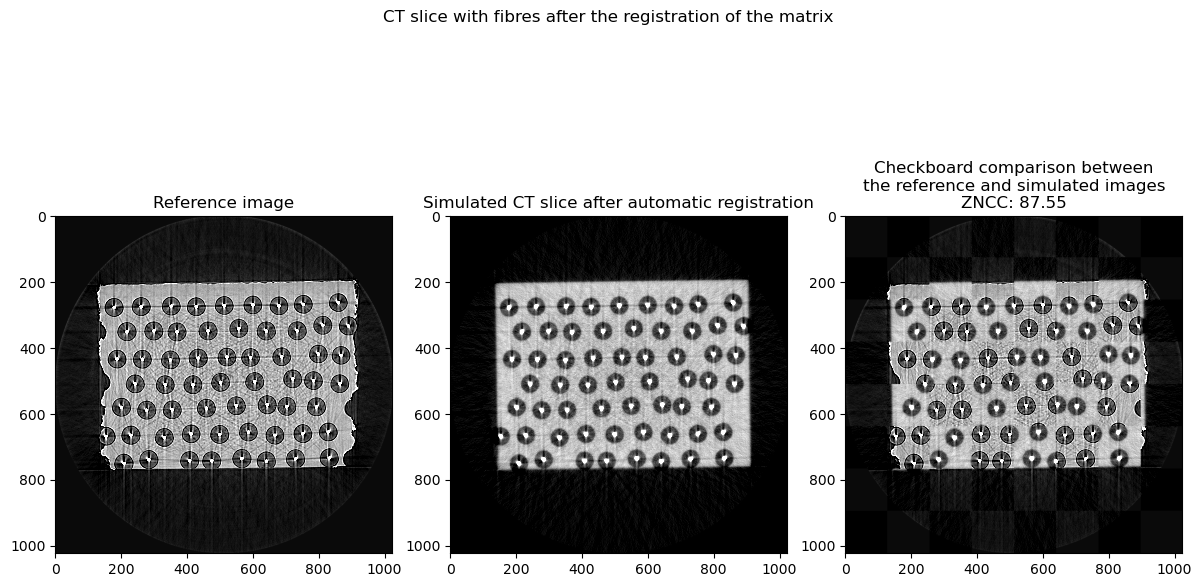

In [73]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('CT slice with fibres after the registration of the matrix')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(normalised_reference_CT, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(normalised_simulated_CT,
                     cmap='gray',
                     norm=norm);

comp_equalized = compare_images(normalised_reference_CT, normalised_simulated_CT, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm);

plt.savefig('plots/simulated_CT_slice_with_noise.pdf');
plt.savefig('plots/simulated_CT_slice_with_noise.png');

## Optimisation of the beam spectrum

In [74]:
def fitnessHarmonics(x):

    global energy_spectrum;
    
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    energy_33_keV = x[0];
    first_order_harmonics = x[1];
    second_order_harmonics = x[2];

    # Normalise the beam spectrum
    total = energy_33_keV + first_order_harmonics + second_order_harmonics;
    energy_33_keV /= total;
    first_order_harmonics /= total;
    second_order_harmonics /= total;

    # The beam specturm. Here we have a polychromatic beam.
    gvxr.resetBeamSpectrum();
    energy_spectrum = [(33, energy_33_keV, "keV"), (66, first_order_harmonics, "keV"), (99, second_order_harmonics, "keV")];

    for energy, percentage, unit in energy_spectrum:
        gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

    # Compute the objective value (no normalisation here)
    objective = math.sqrt(mean_squared_error(reference_sinogram.flatten(), simulated_sinogram.flatten()));
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
        
        # Reconstruct the CT slice
        simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);

        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", np.array(x) / total, header='33keV,66keV,99keV');

        best_fitness_id += 1;

    return objective

In [75]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/spectrum.dat"):
    temp = np.loadtxt("outputs/spectrum.dat");

    # The beam specturm. Here we have a polychromatic beam.
    energy_spectrum = [(33, temp[0], "keV"), (66, temp[1], "keV"), (99, temp[2], "keV")];

# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [0.97, 0.2, 0.1];
    bounds = [[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "spectrum_";
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-4);
    opts['tolx'] = 1e-4;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessHarmonics);

    total = es.result.xbest[0] + es.result.xbest[1] + es.result.xbest[2];
    energy_spectrum = [(33, es.result.xbest[0] / total, "keV"), (66, es.result.xbest[1] / total, "keV"), (99, es.result.xbest[2] / total, "keV")];

    np.savetxt("outputs/spectrum.dat", [es.result.xbest[0] / total, es.result.xbest[1] / total, es.result.xbest[2] / total], header='weight of main energy,weight of first order harmonics,weight of second order harmonics');

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=851494, Thu Apr 29 18:10:29 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 6.790233777334277e+02 1.0e+00 2.36e-01  2e-01  2e-01 0:36.5
    2     14 2.710266191591077e+03 1.4e+00 2.28e-01  2e-01  2e-01 0:46.6
    3     21 1.618025960597630e+03 1.6e+00 2.26e-01  2e-01  2e-01 0:56.7
    4     28 1.716806461023481e+03 1.6e+00 2.52e-01  2e-01  3e-01 1:06.8
    5     35 2.571945696029042e+03 1.9e+00 2.19e-01  1e-01  2e-01 1:16.9
    6     42 5.759469255536430e+02 1.9e+00 1.97e-01  1e-01  2e-01 1:35.8
    7     49 4.486008918813712e+02 1.9e+00 2.01e-01  1e-01  2e-01 1:54.7
    8     56 8.190725918544050e+02 2.2e+00 1.95e-01  9e-02  2e-01 2:04.9
    9     63 5.417669289158210e+02 2.6e+00 1.53e-01  6e-02  2e-01 2:15.0
   10     70 4.174401023648967e+02 2.9e+00 1.32e-01  5e-02  1e-01 2:33.8
   11     77 4.394674174980944e+02 3.0e+00 1.13e-01  4e-02  1e-01 2:43.9
   12     84 3.953122264633439e+02 

In [76]:
if not os.path.exists("plots/spectrum_registration.gif"):
    registration_image_set = createAnimation("outputs/spectrum_simulated_CT_",
                'plots/spectrum_registration.gif');

![Animation of the registration (GIF file)](plots/spectrum_registration.gif)

In [77]:
# Apply the result of the registration
gvxr.resetBeamSpectrum();
for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

In [78]:
for channel in energy_spectrum:
    print(channel);

(33, 0.9565783895953861, 'keV')
(66, 0.01737075206037302, 'keV')
(99, 0.026050858344240937, 'keV')


In [79]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);

# Reconstruct the CT slice
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC spectrum registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC spectrum registration: 87.59


## Optimisation of the phase contrast and the radii

In [80]:
def laplacian(x, sigma):
    """
    This function create a Laplacian kernel with

    $$ g''(x) = \left(\frac{x^2}{\sigma^4} - \frac{1}{\sigma^2}\right) \exp\left(-\frac{x^2}{2\sigma^2}\right) $$
    
    :param array x: 
    :param float sigma:
    :return the convolution kernel
    """
    
    return (np.power(x, 2.) / math.pow(sigma, 4) - 1. / math.pow(sigma, 2)) * np.exp(-np.power(x, 2.) / (2. * math.pow(sigma, 2)));

In [81]:
def getLBuffer(object):

    """
    This function compute the L-buffer of the object over all the angles
    
    :param str object: the name of the object 
    :return the L-buffer over all the angles
    """

    # An empty L-buffer
    L_buffer = [];

    # Get the line of L-buffer for each angle
    for angle_id in range(0, number_of_projections):
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-angular_step * angle_id, 0, 1, 0);

        # Compute the X-ray image
        line_of_L_buffer = np.array(gvxr.computeLBuffer(object));

        # Add the projection
        L_buffer.append(line_of_L_buffer);

    # Return as a numpy array
    return np.array(L_buffer);

In [82]:
def fitnessFunctionLaplacian(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    global fibre_radius;
    global core_radius;

    sigma_core = x[0];
    k_core = x[1];
    sigma_fibre = x[2];
    k_fibre = x[3];
    sigma_matrix = x[4];
    k_matrix = x[5];
    core_radius = x[6];
    fibre_radius = x[7];

    # Load the matrix
    setMatrix(matrix_geometry_parameters);

    # Load the cores and fibres
    setFibres(centroid_set);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(
        [sigma_core, sigma_fibre, sigma_matrix], 
        [k_core, k_fibre, k_matrix], 
        ["core", "fibre", "matrix"]
    );

    # Compute the objective value
    objective = metrics(reference_sinogram, simulated_sinogram);
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
        
        # Reconstruct the CT slice
        simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);

        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", [sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius, fibre_radius], header='sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius_in_um, fibre_radius_in_um');
    
        best_fitness_id += 1;

    return objective

In [83]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/laplacian1.dat"):
    temp = np.loadtxt("outputs/laplacian1.dat");
    sigma_core = temp[0];
    k_core = temp[1];
    sigma_fibre = temp[2];
    k_fibre = temp[3];
    sigma_matrix = temp[4];
    k_matrix = temp[5];
    core_radius = temp[6];
    fibre_radius = temp[7];

# Perform the registration using CMA-ES
else:

    sigma_core = 5.;
    sigma_fibre = 0.75;
    sigma_matrix = 0.6;

    k_core = 1000;
    k_fibre = 1000;
    k_matrix = 1000.0;

    x0 = [
        sigma_core, k_core, 
        sigma_fibre, k_fibre, 
        sigma_matrix, k_matrix, 
        core_radius, fibre_radius
    ];
    
    bounds = [
        [
            0.005, 0.0, 
             0.005, 0.0, 
             0.005, 0.0, 
             0.95 * core_radius, 0.95 * fibre_radius
        ],
        [
            10.0, 2000, 
             2.5, 2000, 
             2.5, 2000, 
             1.15 * core_radius, 1.15 * fibre_radius
        ]
    ];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "laplacian1_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-4);
    opts['tolx'] = 1e-4;
    opts['bounds'] = bounds;
    opts['CMA_stds'] = [0.25, 20.25, 0.25, 20.25, 0.25, 20.25, core_radius * 0.1, fibre_radius * 0.1];

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionLaplacian);

    sigma_core = es.result.xbest[0];
    k_core = es.result.xbest[1];
    sigma_fibre = es.result.xbest[2];
    k_fibre = es.result.xbest[3];
    sigma_matrix = es.result.xbest[4];
    k_matrix = es.result.xbest[5];
    core_radius = es.result.xbest[6];
    fibre_radius = es.result.xbest[7];

    np.savetxt("outputs/laplacian1.dat", [sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius, fibre_radius], header='sigma_core, k_core, sigma_fibre, k_fibre, sigma_matrix, k_matrix, core_radius_in_um, fibre_radius_in_um');

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=879903, Thu Apr 29 18:44:16 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.076012272798531e-01 1.0e+00 2.46e-01  6e-02  5e+00 0:44.1
    2     20 1.072723149959538e-01 1.2e+00 2.37e-01  6e-02  5e+00 1:10.3
    3     30 1.074260206848244e-01 1.3e+00 2.33e-01  6e-02  5e+00 1:27.5
    4     40 1.070165335870282e-01 1.5e+00 2.30e-01  5e-02  5e+00 2:02.9
    5     50 1.070399120218351e-01 1.6e+00 2.07e-01  5e-02  4e+00 2:20.4
    6     60 1.071295037961749e-01 1.6e+00 2.00e-01  4e-02  4e+00 2:37.8
    7     70 1.071295465152031e-01 1.6e+00 2.03e-01  5e-02  4e+00 2:55.2
    8     80 1.073673557296478e-01 1.7e+00 2.23e-01  5e-02  4e+00 3:12.5
    9     90 1.071416242594982e-01 1.8e+00 2.40e-01  6e-02  5e+00 3:30.0
   10    100 1.075464775960256e-01 1.9e+00 2.16e-01  5e-02  4e+00 3:47.3
   11    110 1.072859343503126e-01 1.9e+00 2.06e-01  5e-02  4e+00 4:04.8
   12    120 1.069652222743676e-01

In [84]:
if not os.path.exists("plots/laplacian1_registration.gif"):
    registration_image_set = createAnimation("outputs/laplacian1_simulated_CT_",
                'plots/laplacian1_registration.gif');

![Animation of the registration (GIF file)](plots/laplacian1_registration.gif)

### Apply the result of the registration

In [85]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/laplacian1_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/laplacian1_core.stl");

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

Core diameter: 16 um
Fibre diameter: 107 um


In [86]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(
    [sigma_core, sigma_fibre, sigma_matrix], 
    [k_core, k_fibre, k_matrix], 
    ["core", "fibre", "matrix"]
);

# Reconstruct the CT slice
simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC phase contrast registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC phase contrast registration: 91.66


## Optimisation of the phase contrast and the LSF

In [87]:
old_lsf = copy.deepcopy(lsf_kernel);

In [88]:
def fitnessFunctionLaplacianLSF(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;
    
    global lsf_kernel;

    # sigma_core = x[0];
    k_core = x[0];
    # sigma_fibre = x[2];
    k_fibre = x[1];
    # sigma_matrix = x[4];
    k_matrix = x[2];

    a2 = x[3];
    b2 = x[4];
    c2 = x[5];
    d2 = x[6];
    e2 = x[7];
    f2 = x[8];

    # The response of the detector as the line-spread function (LSF)
    t = np.arange(-20., 21., 1.);
    lsf_kernel=lsf(t*41, a2, b2, c2, d2, e2, f2);
    lsf_kernel/=lsf_kernel.sum();

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(
        [sigma_core, sigma_fibre, sigma_matrix], 
        [k_core, k_fibre, k_matrix], 
        ["core", "fibre", "matrix"]
    );

    # Compute the objective value
    objective = metrics(reference_sinogram, simulated_sinogram);
   
    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        saveMHA("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".mha",
                simulated_sinogram,
                [pixel_spacing_in_mm, angular_step, pixel_spacing_in_mm]);
        
        # Reconstruct the CT slice
        simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);

        # Save the simulated CT slice
        saveMHA("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".mha",
                simulated_CT,
                [pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

        np.savetxt("outputs/" + prefix + "laplacian_" + str(best_fitness_id) + ".dat", [k_core, k_fibre, k_matrix], header='k_core, k_fibre, k_matrix');
        np.savetxt("outputs/" + prefix + "LSF_" + str(best_fitness_id) + ".dat", [a2, b2, c2, d2, e2, f2], header='a2, b2, c2, d2, e2, f2');

        
        best_fitness_id += 1;

    return objective;

In [89]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/laplacian2.dat") and os.path.isfile(output_directory + "/lsf2.dat"):
    temp = np.loadtxt("outputs/laplacian2.dat");
    k_core = temp[0];
    k_fibre = temp[1];
    k_matrix = temp[2];

    temp = np.loadtxt("outputs/lsf2.dat");
    a2 = temp[0];
    b2 = temp[1];
    c2 = temp[2];
    d2 = temp[3];
    e2 = temp[4];
    f2 = temp[5];

# Perform the registration using CMA-ES
else:

    a2 = 601.873;
    b2 = 54.9359;
    c2 = -3.58452;
    d2 = 0.469614;
    e2 = 6.32561e+09;
    f2 = 1.0;

    x0 = [
        k_core,
        k_fibre,
        k_matrix,
        a2, b2, c2, d2, e2, f2
    ];

    bounds = [
        [
            k_core-500,
            k_fibre-500,
            k_matrix-500,
            a2 - a2 / 4.,
            b2 - b2 / 4.,
            c2 + c2 / 4.,
            d2 - d2 / 4.,
            e2 - e2 / 4.,
            f2 - f2/ 4.
        ],
        [
            k_core+500,
            k_fibre+500,
            k_matrix+500,
            a2 + a2 / 4.,
            b2 + b2 / 4.,
            c2 - c2 / 4.,
            d2 + d2 / 4.,
            e2 + e2 / 4.,
            f2 + f2/ 4.
        ]
    ];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "laplacian2_"

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-4);
    opts['tolx'] = 1e-4;
    opts['bounds'] = bounds;
    #opts['seed'] = 987654321;
    # opts['maxiter'] = 5;
    opts['CMA_stds'] = [1250 * 0.2, 1250 * 0.2, 1250 * 0.2,
        a2 * 0.2, b2 * 0.2, -c2 * 0.2, d2 * 0.2, e2 * 0.2, f2 * 0.2];

    es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
    es.optimize(fitnessFunctionLaplacianLSF);

    k_core = es.result.xbest[0];
    k_fibre = es.result.xbest[1];
    k_matrix = es.result.xbest[2];

    a2 = es.result.xbest[3];
    b2 = es.result.xbest[4];
    c2 = es.result.xbest[5];
    d2 = es.result.xbest[6];
    e2 = es.result.xbest[7];
    f2 = es.result.xbest[8];

    np.savetxt("outputs/laplacian2.dat", [k_core, k_fibre, k_matrix], header='k_core, k_fibre, k_matrix');
    np.savetxt("outputs/lsf2.dat", [a2, b2, c2, d2, e2, f2], header='a2, b2, c2, d2, e2, f2');

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=790393, Thu Apr 29 19:43:26 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.026285346850123e-01 1.0e+00 2.34e-01  2e-02  3e+08 0:43.5
    2     20 1.023785373035976e-01 1.2e+00 2.18e-01  2e-02  3e+08 1:11.2
    3     30 1.024207639063879e-01 1.3e+00 2.04e-01  2e-02  3e+08 1:26.8
    4     40 1.025757418321224e-01 1.3e+00 1.86e-01  2e-02  2e+08 1:43.0
    5     50 1.024522131079754e-01 1.4e+00 1.77e-01  2e-02  2e+08 1:59.7
    6     60 1.024899964278362e-01 1.5e+00 1.66e-01  1e-02  2e+08 2:18.0
    7     70 1.023432758364960e-01 1.6e+00 1.64e-01  1e-02  2e+08 2:42.5
    8     80 1.021204130634706e-01 1.7e+00 1.76e-01  2e-02  2e+08 3:21.9
    9     90 1.022005649875590e-01 2.0e+00 1.86e-01  2e-02  2e+08 3:37.4
   10    100 1.021609788322490e-01 2.1e+00 2.00e-01  2e-02  3e+08 3:52.7
   11    110 1.021738691957654e-01 2.2e+00 2.05e-01  2e-02  3e+08 4:07.9
   12    120 1.020838460415897e-01

In [90]:
if not os.path.exists("plots/laplacian2_registration.gif"):
    registration_image_set = createAnimation("outputs/laplacian2_simulated_CT_",
                'plots/laplacian2_registration.gif');

![Animation of the registration (GIF file)](plots/laplacian2_registration.gif)

### Apply the result of the registration

In [91]:
# The response of the detector as the line-spread function (LSF)
t = np.arange(-20., 21., 1.);
lsf_kernel=lsf(t*41, a2, b2, c2, d2, e2, f2);
lsf_kernel/=lsf_kernel.sum();
np.savetxt("outputs/LSF_optimised.txt", lsf_kernel);

In [105]:
# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram(
    [sigma_core, sigma_fibre, sigma_matrix], 
    [k_core, k_fibre, k_matrix], 
    ["core", "fibre", "matrix"]
);

# Reconstruct the CT slice
simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
simulated_CT = iradon(simulated_sinogram.T, theta=theta, circle=True);
normalised_simulated_CT = (simulated_CT - simulated_CT.mean()) / simulated_CT.std();

# Compute the ZNCC
print("ZNCC phase contrast and LSF registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC phase contrast and LSF registration: 92.43


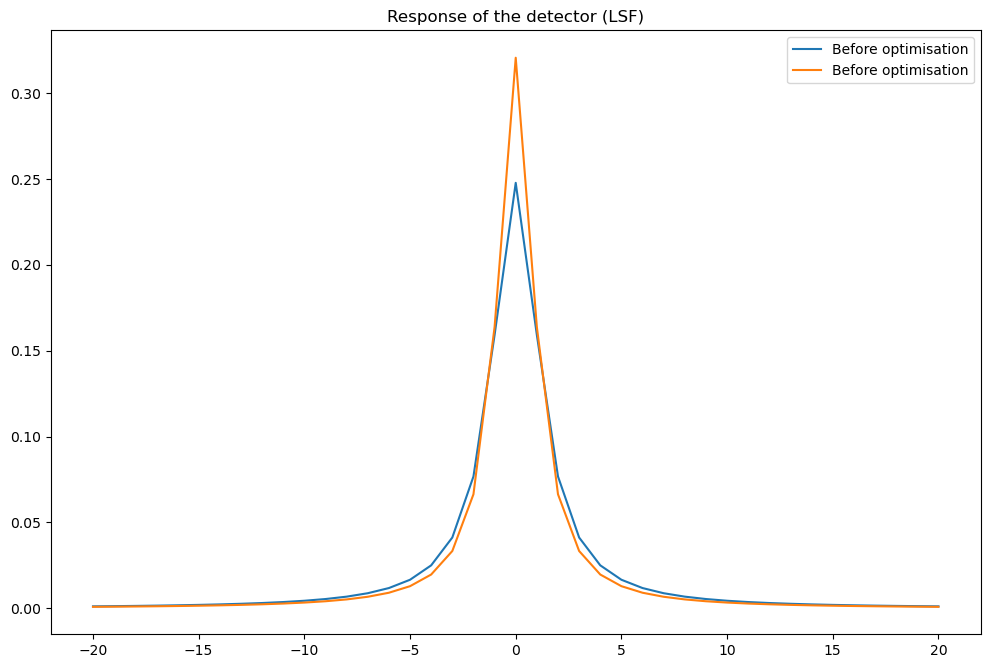

In [106]:
fig=plt.figure();
plt.title("Response of the detector (LSF)");
plt.plot(t, old_lsf, label="Before optimisation");
plt.plot(t, lsf_kernel, label="Before optimisation");
plt.legend();
plt.savefig('plots/LSF_optimised.pdf');
plt.savefig('plots/LSF_optimised.png');

### Extract the fibre in the centre of the CT slices

In [107]:
def findFibreInCentreOfCtSlice():
    global centroid_set;
    global reference_CT;
    global cylinder_position_in_centre_of_slice;

    # Find the cylinder in the centre of the image
    cylinder_position_in_centre_of_slice = None;
    best_distance = sys.float_info.max;

    for centre in centroid_set:
        distance = math.pow(centre[0] - reference_CT.shape[1] / 2,2 ) + math.pow(centre[1] - reference_CT.shape[0] / 2, 2);

        if best_distance > distance:
            best_distance = distance;
            cylinder_position_in_centre_of_slice = copy.deepcopy(centre);

    return cylinder_position_in_centre_of_slice;

In [113]:
findFibreInCentreOfCtSlice();

reference_fibre_in_centre = np.array(copy.deepcopy(reference_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));
test_fibre_in_centre      = np.array(copy.deepcopy(simulated_CT[cylinder_position_in_centre_of_slice[1] - roi_length:cylinder_position_in_centre_of_slice[1] + roi_length, cylinder_position_in_centre_of_slice[0] - roi_length:cylinder_position_in_centre_of_slice[0] + roi_length]));

profile_reference = copy.deepcopy(np.diag(reference_fibre_in_centre));
profile_test = copy.deepcopy(np.diag(test_fibre_in_centre));

reference_fibre_in_centre -= reference_fibre_in_centre.mean();
reference_fibre_in_centre /= reference_fibre_in_centre.std();

test_fibre_in_centre -= test_fibre_in_centre.mean();
test_fibre_in_centre /= test_fibre_in_centre.std();

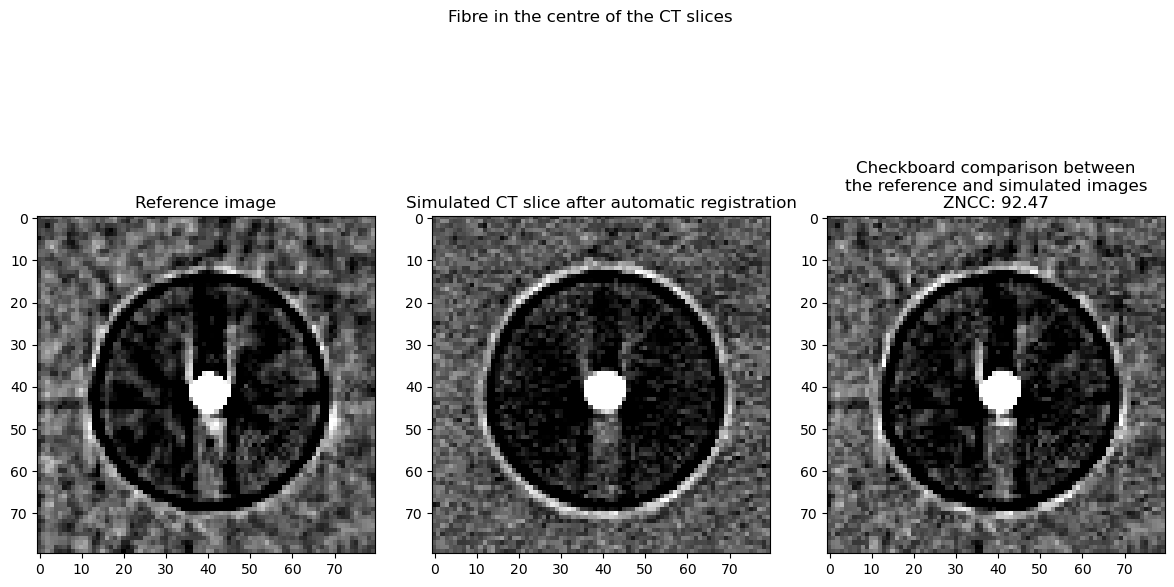

In [121]:
norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('Fibre in the centre of the CT slices')

ax1.set_title("Reference image");
imgplot1 = ax1.imshow(reference_fibre_in_centre, cmap="gray", 
                     norm=norm);

ax2.set_title("Simulated CT slice after automatic registration");
imgplot2 = ax2.imshow(test_fibre_in_centre,
                     cmap='gray',
                     norm=norm);

comp_equalized = compare_images(reference_fibre_in_centre, test_fibre_in_centre, method='checkerboard');
ax3.set_title("Checkboard comparison between\n" + 
              "the reference and simulated images\nZNCC: " + 
              "{:.2f}".format(100.0 * np.mean(np.multiply(reference_fibre_in_centre, test_fibre_in_centre))));
imgplot3 = ax3.imshow(comp_equalized,
                     cmap='gray',
                     norm=norm);

plt.savefig('plots/simulated_CT_slice_with_fibres_after_cube_registration.pdf');
plt.savefig('plots/simulated_CT_slice_with_fibres_after_cube_registration.png');

183.87853883690607
182.36294362794987


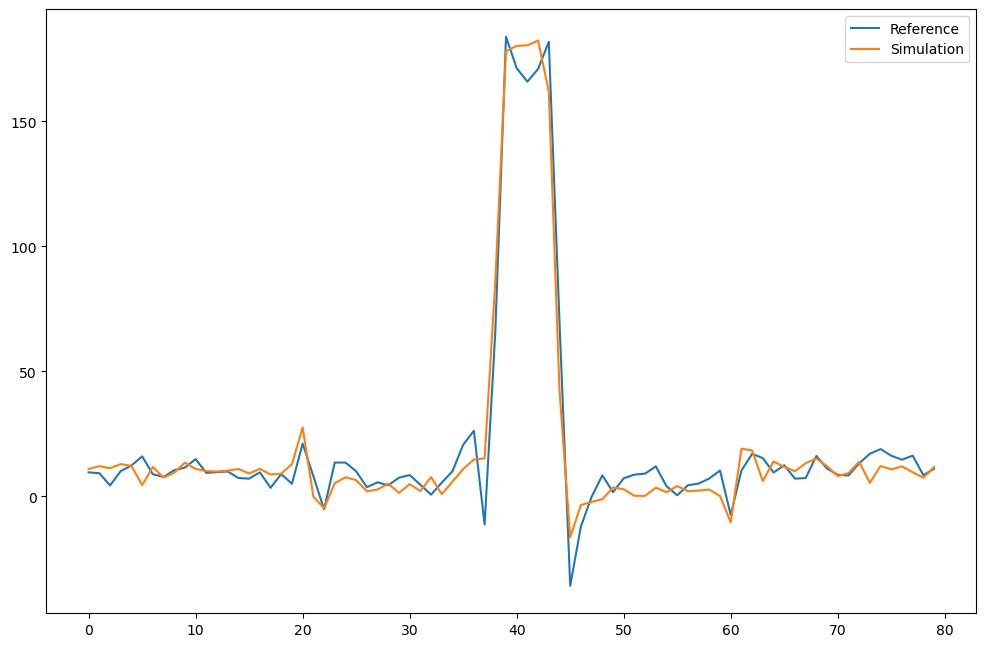

In [115]:
plt.figure()

plt.plot(profile_reference, label="Reference");
plt.plot(profile_test, label="Simulation");
plt.legend();